In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import nutpie

print(f"Running on PyMC v{pm.__version__}")

# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Running on PyMC v5.20.0


In [2]:
# set the genuine model constants
sigma_true = 1
alpha_true = np.array([1, 1.5, 2.5])

# number of fake data points
N = 277
X = np.empty((N,3))
X[:,0] = np.ones(N)
X[:,1:] = np.random.randn(N,2)

# simulate epsilon as N(0, sigma_true**2)
epsilon = rng.normal(size=N) * sigma_true
Y = X @ alpha_true + epsilon

basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=1.5, sigma=2, shape=3)
    sigma = pm.HalfNormal("sigma", sigma=2)

    predictors = pm.Data("predictors", X)

    # Expected value of outcome
    # mu = alpha[0] + alpha[1] * X1 + alpha[2] * X2
    mu = predictors @ alpha


    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)


In [3]:
compiled_model = nutpie.compile_pymc_model(basic_model)

/home/jake/miniforge3/envs/pymc_env/lib/python3.12/site-packages/pymc/pytensorf.py:1066: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
/home/jake/miniforge3/envs/pymc_env/lib/python3.12/site-packages/pymc/pytensorf.py:1066: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(


In [4]:
trace_pymc = nutpie.sample(compiled_model,draws=2749, chains=5)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,3049,0,0.99,3
,3049,0,0.98,3
,3049,0,0.98,3
,3049,0,1.02,3
,3049,0,0.99,3


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],1.09,0.06,0.97,1.20,0.0,0.0,22966.22,11344.05,1.0
alpha[1],1.52,0.06,1.41,1.63,0.0,0.0,22244.97,11936.92,1.0
alpha[2],2.56,0.06,2.44,2.68,0.0,0.0,22795.31,10991.35,1.0
sigma_log__,0.02,0.04,-0.06,0.11,0.0,0.0,22691.45,11104.26,1.0
sigma,1.02,0.04,0.94,1.11,0.0,0.0,22691.45,11104.26,1.0


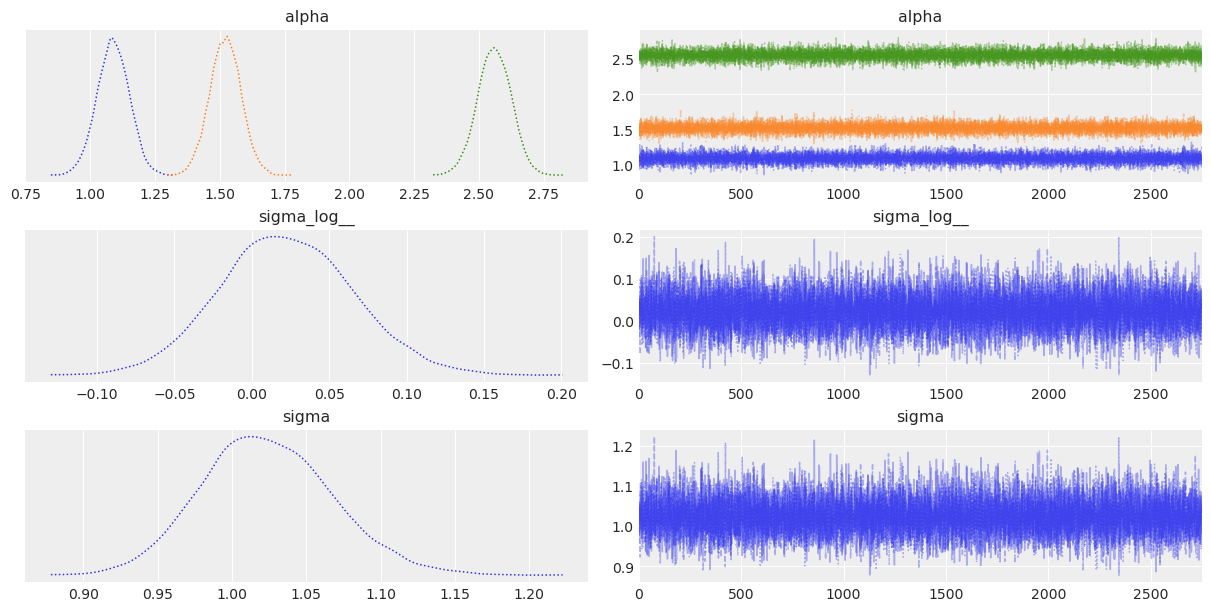

In [5]:
az.plot_trace(trace_pymc, combined=True)
az.summary(trace_pymc, round_to=2)


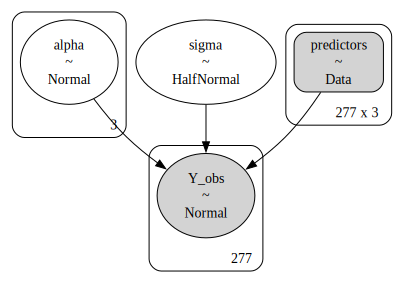

In [6]:
pm.model_to_graphviz(basic_model)

## Posterior Predictive

In [7]:
with basic_model:
    pp = pm.sample_posterior_predictive(trace_pymc)

Sampling: [Y_obs]


Output()

In [8]:
pp.posterior_predictive

<xarray.Dataset> Size: 30MB
Dimensions:      (chain: 5, draw: 2749, Y_obs_dim_2: 277)
Coordinates:
  * chain        (chain) int64 40B 0 1 2 3 4
  * draw         (draw) int64 22kB 0 1 2 3 4 5 ... 2743 2744 2745 2746 2747 2748
  * Y_obs_dim_2  (Y_obs_dim_2) int64 2kB 0 1 2 3 4 5 ... 271 272 273 274 275 276
Data variables:
    Y_obs        (chain, draw, Y_obs_dim_2) float64 30MB -4.879 0.3019 ... 1.916
Attributes:
    created_at:                 2025-02-09T16:28:07.269757+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.0

<Axes: xlabel='Y_obs'>

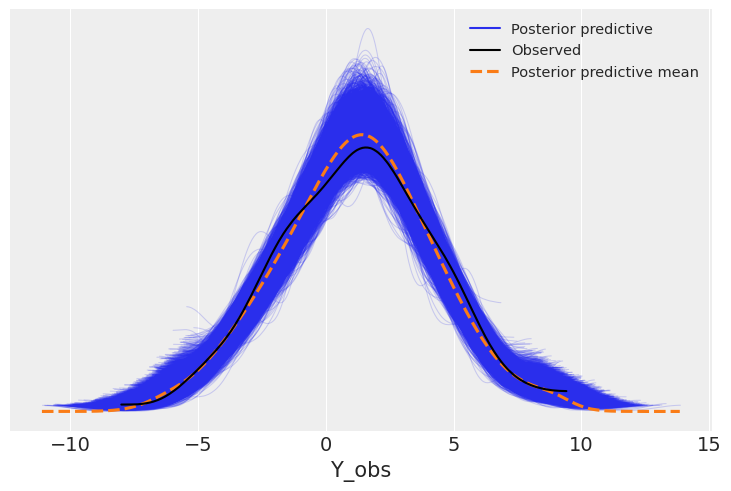

In [9]:
az.plot_ppc(pp)

In [10]:
# good to know
all(pp['observed_data']['Y_obs'] == Y)
# Gives True

True

In [11]:
pp.posterior_predictive

<xarray.Dataset> Size: 30MB
Dimensions:      (chain: 5, draw: 2749, Y_obs_dim_2: 277)
Coordinates:
  * chain        (chain) int64 40B 0 1 2 3 4
  * draw         (draw) int64 22kB 0 1 2 3 4 5 ... 2743 2744 2745 2746 2747 2748
  * Y_obs_dim_2  (Y_obs_dim_2) int64 2kB 0 1 2 3 4 5 ... 271 272 273 274 275 276
Data variables:
    Y_obs        (chain, draw, Y_obs_dim_2) float64 30MB -4.879 0.3019 ... 1.916
Attributes:
    created_at:                 2025-02-09T16:28:07.269757+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.0

Text(0.5, 0, 'Predictor (X1)')

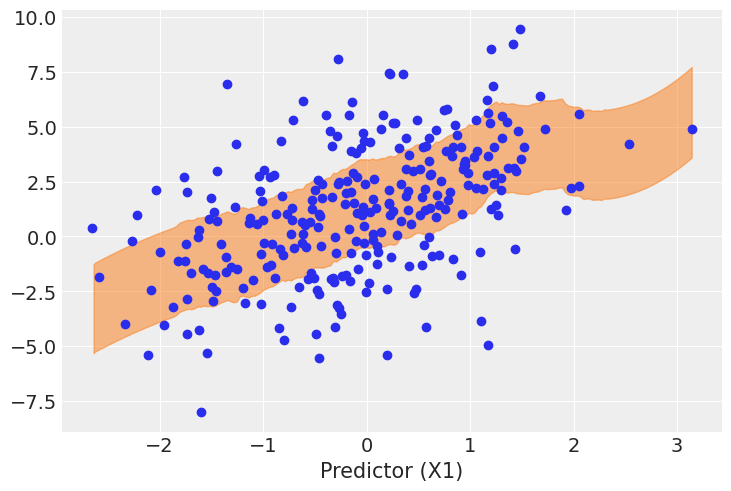

In [12]:
fig, ax = plt.subplots()

az.plot_hdi(X[:,1], pp['posterior_predictive']['Y_obs'],hdi_prob=0.95)
ax.scatter(X[:,1], pp.observed_data["Y_obs"])

ax.set_xlabel("Predictor (X1)")

In [13]:
pp['posterior_predictive']['Y_obs']

<xarray.DataArray 'Y_obs' (chain: 5, draw: 2749, Y_obs_dim_2: 277)> Size: 30MB
array([[[-4.87920104e+00,  3.01947146e-01, -1.46439915e+00, ...,
          3.79301770e+00,  4.95448499e+00,  1.58720716e-01],
        [-2.48802698e+00,  1.40391582e+00, -9.77879801e-01, ...,
          5.24230653e+00,  5.44856255e+00, -2.00394308e-01],
        [-5.91779417e+00,  2.91424176e+00, -9.50306998e-02, ...,
          5.16740619e+00,  6.47140325e+00,  1.15748053e+00],
        ...,
        [-3.70586415e+00,  1.53627286e+00, -2.02130600e+00, ...,
          6.85985734e+00,  5.46534038e+00,  1.13074173e-01],
        [-2.04527501e+00,  1.40713761e+00,  6.86089338e-01, ...,
          4.40439451e+00,  4.52088622e+00,  1.46801838e+00],
        [-2.35073403e+00,  1.31769541e+00, -7.52418294e-01, ...,
          5.86749963e+00,  3.26751927e+00,  7.97915461e-01]],

       [[-4.49561744e+00,  8.64969414e-01, -1.41876080e+00, ...,
          3.30274272e+00,  4.80111670e+00,  1.34045362e+00],
        [-2.52211916e+00,  2.63431719e+00, -2.58731197e+00, ...,
          3.90960911e+00,  4.50761549e+00,  9.13676037e-01],
        [-3.17491495e+00,  1.35046570e+00, -6.73025464e-01, ...,
          3.27148408e+00,  5.70289670e+00,  1.26262632e+00],
...
        [-3.03673118e+00,  1.09817002e+00, -8.04486607e-01, ...,
          4.67641115e+00,  4.40125581e+00,  1.20282009e+00],
        [-5.39087615e+00, -1.32243795e-01, -9.64587021e-01, ...,
          3.82719741e+00,  5.92203384e+00,  1.64373539e+00],
        [-4.62517953e+00,  1.54522602e+00, -2.73954793e-01, ...,
          2.76595383e+00,  3.92188509e+00,  7.04982842e-01]],

       [[-1.70584163e+00,  1.73993824e+00,  2.09579362e-01, ...,
          4.96703235e+00,  5.47594928e+00,  1.11907286e+00],
        [-3.45206911e+00,  1.56452983e+00, -2.11340640e-01, ...,
          4.58461074e+00,  6.03284518e+00, -3.97923973e-03],
        [-3.70558856e+00,  1.50006213e+00, -1.05160257e+00, ...,
          3.45699685e+00,  6.77032342e+00, -4.43058568e-01],
        ...,
        [-3.72888538e+00, -5.35899147e-01, -7.53023846e-01, ...,
          4.47072562e+00,  3.20252254e+00,  2.39833480e+00],
        [-4.10268021e+00,  2.30541647e+00, -1.88250212e+00, ...,
          3.90733687e+00,  5.65922680e+00,  9.50250072e-01],
        [-6.62609796e+00,  9.83035586e-01,  2.72061107e-01, ...,
          3.88069341e+00,  7.83138211e+00,  1.91625609e+00]]])
Coordinates:
  * chain        (chain) int64 40B 0 1 2 3 4
  * draw         (draw) int64 22kB 0 1 2 3 4 5 ... 2743 2744 2745 2746 2747 2748
  * Y_obs_dim_2  (Y_obs_dim_2) int64 2kB 0 1 2 3 4 5 ... 271 272 273 274 275 276

### TODO

Read the pymc docs on [posterior predictive](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html#prediction).

Another guide on [posterior prediction](https://www.pymc-labs.com/blog-posts/out-of-model-predictions-with-pymc/)
that was mentioned in
[this forum](https://discourse.pymc.io/t/model-compilation-avoidance-when-reusing-a-model/13863).